# Trend Analysis and Forecasting of COVID-19 outbreak in India

COVID-19 is spreading really fast around the world. The current study describes the situation of the outbreak of this disease in India and predicts the number of cases expected to rise in India.

The data has been considered from the https://www.covid19india.org/ and covers up the time period from 30th January 2020 when the first case occurred in India till the end of 22th May 2021.The objective of the current study is to analyze the COVID-19 outbreak situation in India and assess the trends in near future. Also, the study aims to take an overview of the preparedness levels of this outbreak from Indian Government. The scope of this study is limited to building forecasting models for Indian region and uses time series-based forecasting methods which are easy to build and easy to understand in these kinds of critical conditions.



In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
import itertools
import statsmodels.api as sm
import warnings
import plotly
import plotly.express as px
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

In [21]:
covid19_daily=pd.read_csv(r'C:\Users\mahendra\Desktop\analytics\projects\Covid19_india\case_time_series.csv')

In [6]:
covid19_daily.head()

,Date,Date_YMD,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,30 January 2020,2020-01-30,1,1,0,0,0,0
1,31 January 2020,2020-01-31,0,1,0,0,0,0
2,1 February 2020,2020-02-01,0,1,0,0,0,0
3,2 February 2020,2020-02-02,1,2,0,0,0,0
4,3 February 2020,2020-02-03,1,3,0,0,0,0


In [7]:
covid19_daily['Date_YMD'] = pd.to_datetime(covid19_daily['Date_YMD'],dayfirst = True)

In [8]:
data=covid19_daily[['Date_YMD' ,'Daily Confirmed']]
train=data[data.Date_YMD<'2021-04-01']
test=data[data.Date_YMD>="2021-04-01"]
test=test[test.Date_YMD<="2021-04-30"]

# ARIMA MODEL

ARIMA short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

ARIMA Parameters:

Each component in ARIMA functions as a parameter with a standard notation. For ARIMA models, a standard notation would be ARIMA with p, d, and q, where integer values substitute for the parameters to indicate the type of ARIMA model used. 

The parameters can be defined as:

•	p: the number of lag observations in the model; also known as the lag order.

•	d: the number of times that the raw observations are differenced; also known as the degree of differencing.

•	q: the size of the moving average window; also known as the order of the moving average


In [9]:
best_score, best_cfg = float("inf"), None
for i in range(5):
    for j in range(3):
        for k in range(3):
            order = (i,j,k)
            arima = ARIMA(train['Daily Confirmed'], order=order)
            arima = arima.fit()
            forecast = arima.forecast(steps=30)
            pred = list(forecast.values)
            errors = r2_score(test['Daily Confirmed'],forecast)
            if abs(errors) < abs(best_score):
                best_score, best_cfg = errors, order
print('Best ARIMA',(best_cfg, best_score))

Best ARIMA ((2, 2, 0), 0.03288126018824988)


In [10]:
# example of calculate the root mean squared error
arima = ARIMA(train['Daily Confirmed'], order=best_cfg)
arima = arima.fit()
forecast = arima.forecast(steps=30)
pred = list(forecast.values)
errors = r2_score(test['Daily Confirmed'],forecast)
rsme_score=mean_squared_error(test['Daily Confirmed'],forecast)
print(errors)
print(rsme_score)

0.03288126018824988
10430999600.118567


Inferences from the Figure 6.1 are as follows:

•	Accuracy score of ARIMA model:

        R-squared: 0.03288
        
        Root-mean-square error (RMSE): 10430999600

•	Best Parameters:(p, d, q) = (2,2,0)


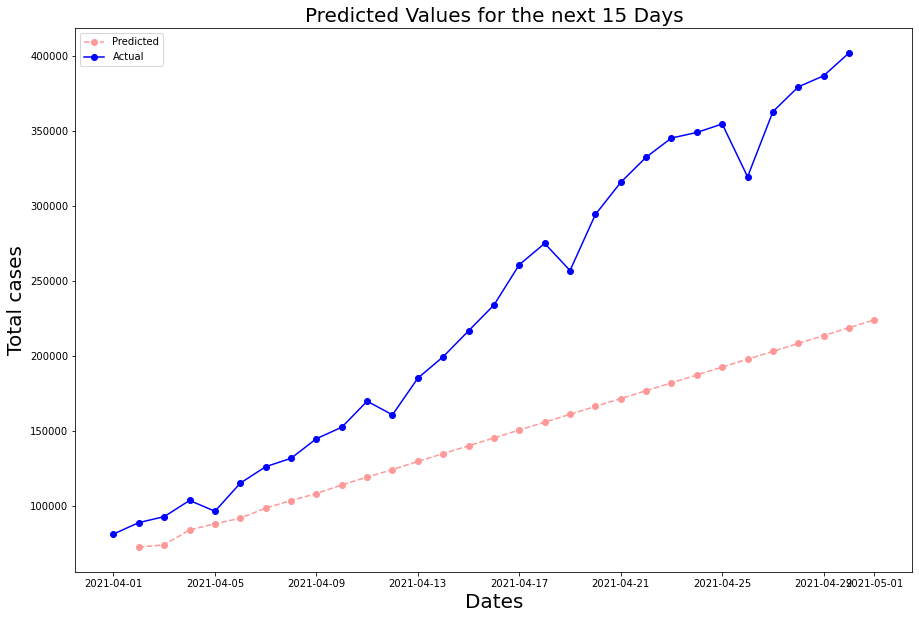

In [11]:
start_date = test['Date_YMD'].min()
prediction_dates = []
for i in range(30):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
plt.plot_date(x=test.Date_YMD,y=test['Daily Confirmed'],linestyle = '-',color = 'blue',label = 'Actual');
plt.legend();

In [12]:
#forecasting for next 15 days
arima = ARIMA(data['Daily Confirmed'], order=best_cfg)
arima = arima.fit()
forecast = arima.forecast(steps=15)


#save forcastef value into dataframe
times = pd.date_range('2021-05-23', periods=15, freq='D')
forecast_df=pd.DataFrame(data=times,columns=['Date'])
forecast_df['ARIMA_model']=forecast.values

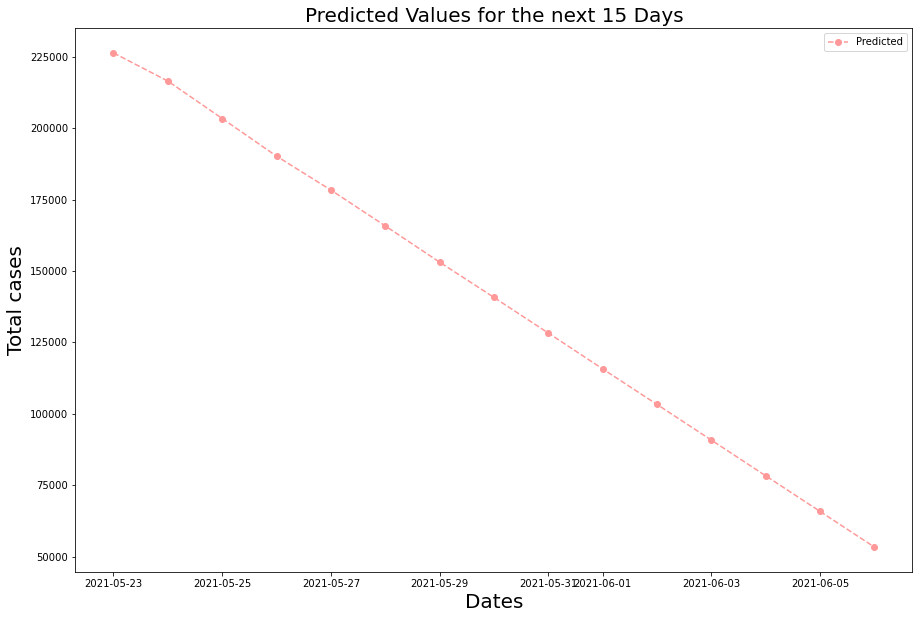

In [13]:
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

plt.plot_date(y= forecast_df['ARIMA_model'],x=forecast_df['Date'],linestyle ='dashed',color = '#ff9999',label = 'Predicted');

plt.legend();

# SARIMA Model

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.
It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

SARIMA Parameters:

Trend Elements

    There are three trend elements that require configuration.
    They are the same as the SARIMA model; specifically:
    p: Trend autoregression order.
    d: Trend difference order.
    q: Trend moving average order.

Seasonal Elements

    There are four seasonal elements that are not part of ARIMA that must be configured; the are:
    P: Seasonal autoregressive order.
    D: Seasonal difference order.
    Q: Seasonal moving average order.
    m: The number of time steps for a single seasonal period.


In [14]:
p = d = q = range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2],2) for x in list(itertools.product(p, d, q))]

In [15]:
best_score, best_param,best_param_seasonal = float("inf"), None ,None
for param in pdq:
    for param_seasonal in seasonal_pdq:
            sarima= sm.tsa.statespace.SARIMAX(train['Daily Confirmed'],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            sarima = sarima.fit()
            forecast = sarima.forecast(steps= 30)
            pred = list(forecast.values)
            errors = r2_score(test['Daily Confirmed'],forecast)
            if abs(errors) < abs(best_score):
                best_score,best_param,best_param_seasonal =errors,param,param_seasonal
print('Best SARIMA',best_score, best_param,best_param_seasonal)

Best SARIMA -0.0915007917436712 (1, 1, 1) (1, 1, 0, 2)


In [16]:
# example of calculate the root mean squared error
sarima =sm.tsa.statespace.SARIMAX(train['Daily Confirmed'],order=best_param,seasonal_order=best_param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
sarima = sarima.fit()
forecast = sarima.forecast(steps= 30)
sarima_Pred = list(forecast.values)
errors = r2_score(test['Daily Confirmed'],forecast)
rsme_score=mean_squared_error(test['Daily Confirmed'],forecast)
print(errors)
print(rsme_score)

-0.0915007917436712
11772540282.306507


Inference from the Figure 6.3 are as follows:

•	Accuracy score of SARIMA model:

    R-squared: -0.091500

    Root-mean-square error (RMSE): 11772540282

•	Best Parameters:    

    Trend Elements (p, d, q) = (1,1,1)
     Seasonal Elements  (P, D, Q, m) = (1,1,0,2)


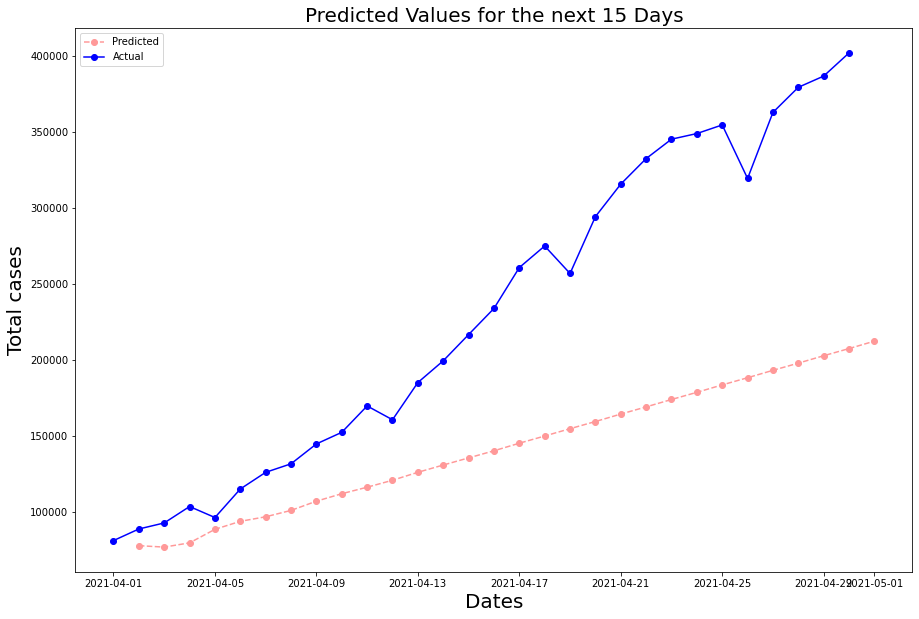

In [18]:
start_date = test['Date_YMD'].min()
prediction_dates = []
for i in range(30):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

plt.plot_date(y=sarima_Pred,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
plt.plot_date(x=test.Date_YMD,y=test['Daily Confirmed'],linestyle = '-',color = 'blue',label = 'Actual');
plt.legend();

In [24]:
sarima =sm.tsa.statespace.SARIMAX(data['Daily Confirmed'],order=best_param,seasonal_order=best_param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
sarima = sarima.fit()
forecast_sarima = sarima.forecast(steps=15)
# save forcastef value into dataframe
forecast_df['SARIMA_model']=forecast_sarima.values

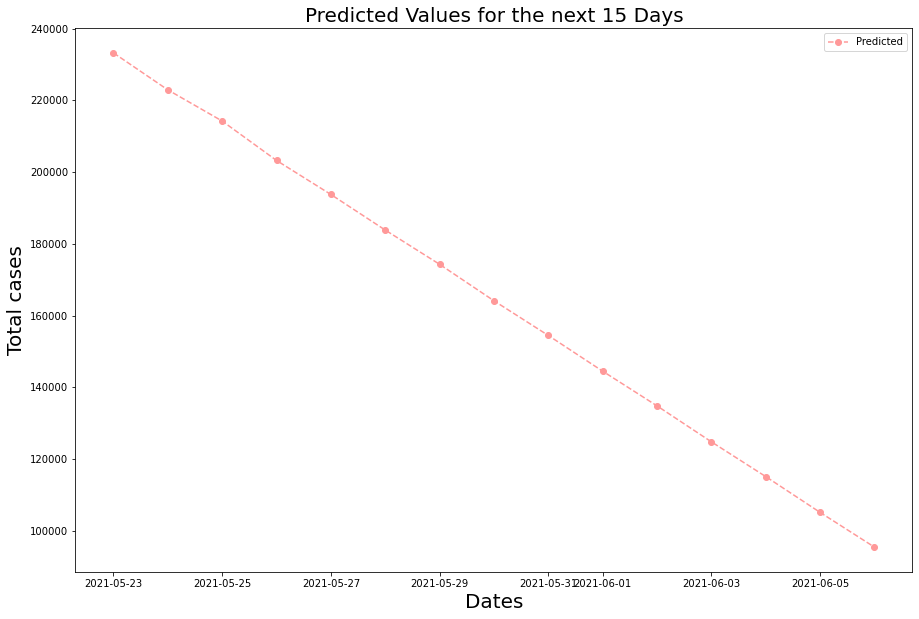

In [28]:
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

plt.plot_date(y= forecast_df['SARIMA_model'],x=forecast_df['Date'],linestyle ='dashed',color = '#ff9999',label = 'Predicted');

plt.legend();

# 3. Prophet Model 

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

We use a decomposable time series model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:

    •	g(t): piecewise linear or logistic growth curve for modelling non-periodic changes in time series
    •	s(t): periodic changes (e. g. weekly/yearly seasonality)
    •	h(t): effects of holidays (user provided) with irregular schedules
    •	εt: error term accounts for


In [17]:
from fbprophet import Prophet
train.columns = ['ds','y']
train['ds'] = pd.to_datetime(train['ds'])

train of model is done by using Google colab

Link; https://colab.research.google.com/drive/1jJ3a9UL8p5uKCBOcwmgIQCFWBa9erM1v

In [ ]:
# train of model is done by google colab
m = Prophet()
m.fit(train)
future=m.make_future_dataframe(periods=30)
prop_forecast=m.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(30)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
forecast_Prophet=pd.read_csv(r'C:\Users\mahendra\Desktop\analytics\projects\Covid19_india\file01_by_Prophet Model (1).csv')

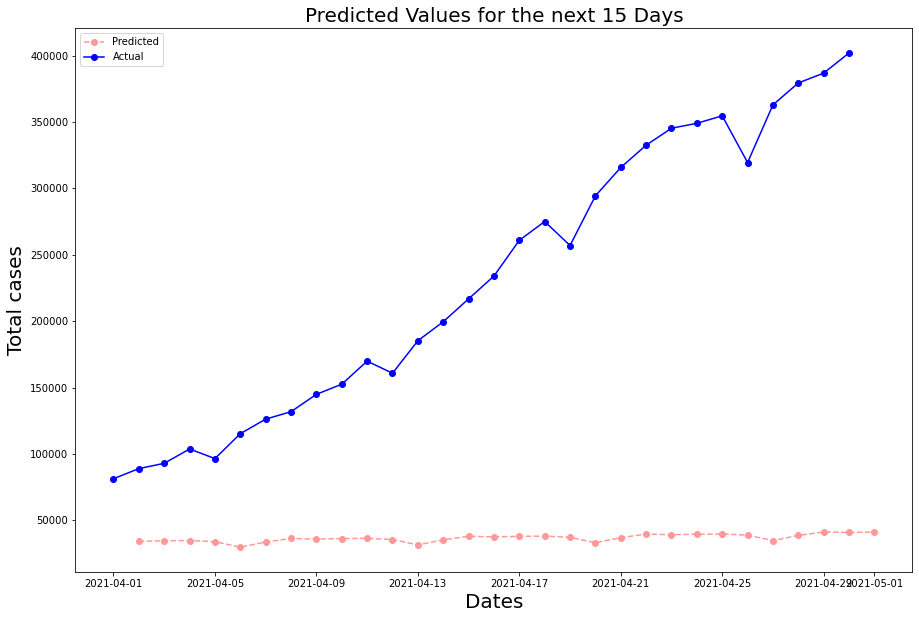

In [30]:
start_date = test['Date_YMD'].min()
prediction_dates = []
for i in range(30):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

plt.plot_date(y=forecast_Prophet.yhat,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
plt.plot_date(x=test.Date_YMD,y=test['Daily Confirmed'],linestyle = '-',color = 'blue',label = 'Actual');
plt.legend();

In [32]:
errors = r2_score(test['Daily Confirmed'],forecast_Prophet.yhat)
rsme_score=mean_squared_error(test['Daily Confirmed'],forecast_Prophet.yhat)
print(errors)
print(rsme_score)

-3.4641713666087677
48148968501.0352


Inference from the Figure 6.5 are as follows:
Accuracy score of SARIMA model:

    R-squared: -3.4641713666087677
    
    Root-mean-square error (RMSE): 48148968501


In [ ]:
data.columns = ['ds','y']
data['ds'] = pd.to_datetime(data['ds'])
m = Prophet()
m.fit(data)
future=m.make_future_dataframe(periods=15)
prop_forecast=m.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(15)

In [33]:
pred_Prophet=pd.read_csv(r'C:\Users\mahendra\Desktop\analytics\projects\Covid19_india\pred_by_Prophet Model (2).csv')

In [34]:
forecast_df['Prophet_model']=pred_Prophet.yhat

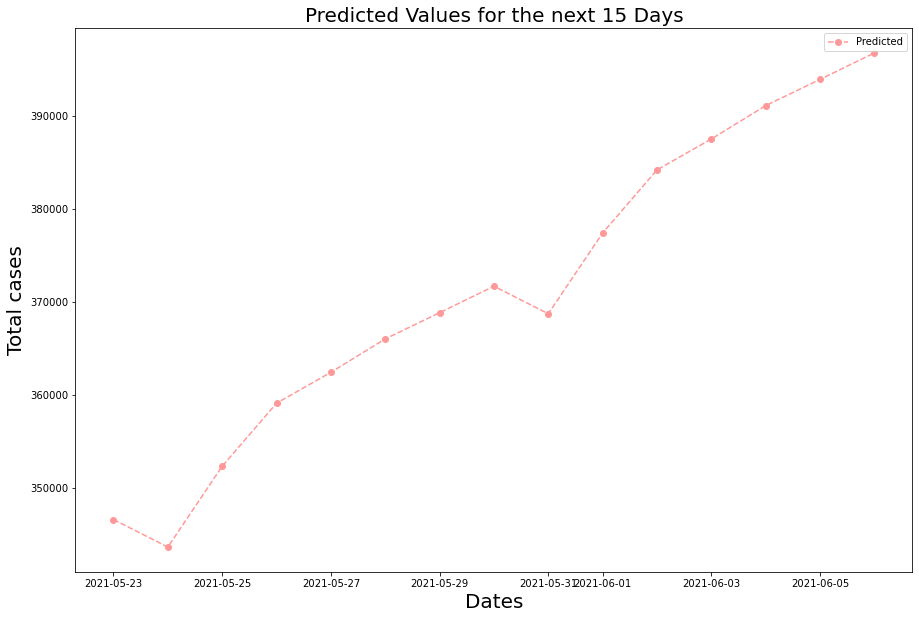

In [35]:
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

plt.plot_date(y= forecast_df['Prophet_model'],x=forecast_df['Date'],linestyle ='dashed',color = '#ff9999',label = 'Predicted');

plt.legend();